In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from astropy.io import fits
from astropy.wcs import WCS
from scipy.interpolate import UnivariateSpline

Tcmb=2.725
k_B = 1.38E-23

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Wed Jul  8 22:28:54 2020...


In [3]:
print katcali.__version__

0.2.1


In [4]:
def cal_freq(ch):
    v_min=856.0 
    v_max=1712.0 
    dv=0.208984375
    assert((v_max-v_min)/dv==4096)
    freq_MHz=ch*dv+v_min
    freq=freq_MHz*1e6
    return freq

In [5]:
pix_deg=0.3
std_sigma=2.5 #the smaller number will make more data be delated 

ch_plot=800

In [6]:
p_radec=np.loadtxt('radio_source.txt')
ptr_pix=np.loadtxt('radio_source_pix_'+str(pix_deg)+'deg.txt')
ptr_ra_pix,ptr_dec_pix=ptr_pix[:,0],ptr_pix[:,1]
output_file='./'

In [7]:
fname_list=['1551037708','1551055211','1553966342','1554156377','1556052116','1556138397','1562857793']

# check the dish number before/after small rfi filter

In [8]:
i_iter=2

In [9]:
dish_count_ori=np.zeros(64)
dish_count_filter=np.zeros(64)

for a_i in range(64):
    ant='m'+ "%03d" % a_i
    #print ant
    
    for f_i in range(len(fname_list)):
        fname=fname_list[f_i]
        #print fname
        
        try:

            #Fits1='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
            #Tsky_cube = fits.open(Fits1)[0].data
            Fits2='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits2)[0].data
            #assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
            assert((np.isnan(Tresi_cube)).all()==False)
            m=pickle.load(open('/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p'+str(pix_deg)+'d/p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'/mask/'+str(fname)+'_'+str(ant)+'_level6_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'_mask'))
            ch_mask=m['ch_mask']
            
            if (np.isnan(Tresi_cube[:,:,ch_plot])==True).all()==False:
                dish_count_ori[a_i]+=1
            if ch_mask[ch_plot]==False:
                dish_count_filter[a_i]+=1

        except IOError:
            print 'no data cube for '+ fname+', '+ant
    
    print ant, dish_count_ori[a_i],dish_count_filter[a_i]
            

no data cube for 1562857793, m000
m000 6.0 6.0
no data cube for 1551037708, m001
no data cube for 1562857793, m001
m001 5.0 5.0
no data cube for 1562857793, m002
m002 6.0 5.0
no data cube for 1562857793, m003
m003 6.0 6.0
no data cube for 1553966342, m004
m004 6.0 5.0
no data cube for 1553966342, m005
no data cube for 1556052116, m005
m005 5.0 5.0
no data cube for 1562857793, m006
m006 6.0 5.0
no data cube for 1551037708, m007
m007 6.0 5.0
no data cube for 1551037708, m008
m008 6.0 4.0
no data cube for 1553966342, m009
m009 6.0 5.0
m010 7.0 7.0
m011 7.0 7.0
m012 7.0 6.0
m013 7.0 3.0
no data cube for 1553966342, m014
no data cube for 1554156377, m014
no data cube for 1556052116, m014
no data cube for 1556138397, m014
m014 2.0 1.0
no data cube for 1556138397, m015
m015 6.0 3.0
no data cube for 1553966342, m016
no data cube for 1556138397, m016
m016 5.0 2.0
no data cube for 1553966342, m017
no data cube for 1554156377, m017
no data cube for 1556052116, m017
no data cube for 1556138397, m0

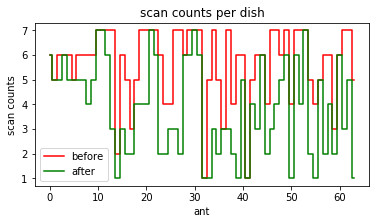

In [10]:
plt.figure(figsize=(6,3))
plt.step(dish_count_ori,'r-',where='mid')
plt.step(dish_count_filter,'g--',where='mid')
plt.xlabel('ant')
plt.ylabel('scan counts')
plt.legend(['before','after'])
plt.title('scan counts per dish')
plt.show()
            

In [11]:
ratio=dish_count_filter/dish_count_ori
print ratio

[ 1.          1.          0.83333333  1.          0.83333333  1.
  0.83333333  0.83333333  0.66666667  0.83333333  1.          1.
  0.85714286  0.42857143  0.5         0.5         0.4         0.66666667
  0.8         0.57142857  0.57142857  1.          0.85714286  0.33333333
  0.5         0.75        0.42857143  0.28571429  1.          0.85714286
  1.          0.85714286  1.          0.2         0.42857143  0.4         1.
  0.42857143  0.5         0.16666667  0.83333333  1.          0.8         0.5
  1.          0.5         0.42857143  0.57142857  0.83333333  0.85714286
  0.25        0.85714286  0.57142857  1.          0.4         0.25        1.
  0.33333333  0.66666667  0.66666667  1.          0.42857143  0.71428571
  0.2       ]


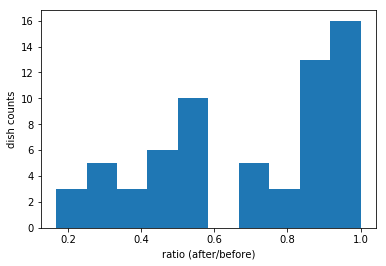

In [12]:
plt.hist(ratio,bins=10)
plt.xlabel('ratio (after/before)')
plt.ylabel('dish counts')
plt.show()

In [13]:
for i in range(64):
    if ratio[i]<0.6:
        print i,

13 14 15 16 19 20 23 24 26 27 33 34 35 37 38 39 43 45 46 47 50 52 54 55 57 61 63


# show the per-dish maps

In [14]:
print ch_plot

800


In [15]:
i_iter=2
pix_deg=0.3
std_sigma=2.5

# cube 1: 1551037708 m000
-------------------------------------------
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133
-------------------------------------------
***stastic cubes initialized
# cube 2: 1551055211 m000
# cube 3: 1553966342 m000
# cube 4: 1554156377 m000
# cube 5: 1556052116 m000
# cube 6: 1556138397 m000
no data cube for 1562857793, m000
3.24444732855 0.11328943782
0.0014347940217 0.0647069946302


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in divide


no data cube for 1551037708, m001
# cube 1: 1551055211 m001
-------------------------------------------
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133
-------------------------------------------
***stastic cubes initialized
# cube 2: 1553966342 m001
# cube 3: 1554156377 m001
# cube 4: 1556052116 m001
# cube 5: 1556138397 m001
no data cube for 1562857793, m001
3.24020173784 0.102879733947
-0.000502066235984 0.06491139891
# cube 1: 1551037708 m002
-------------------------------------------
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : 143.0  -2.5  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  41  133
-------------------------------------------
***stastic cubes initialized
# cube 2: 

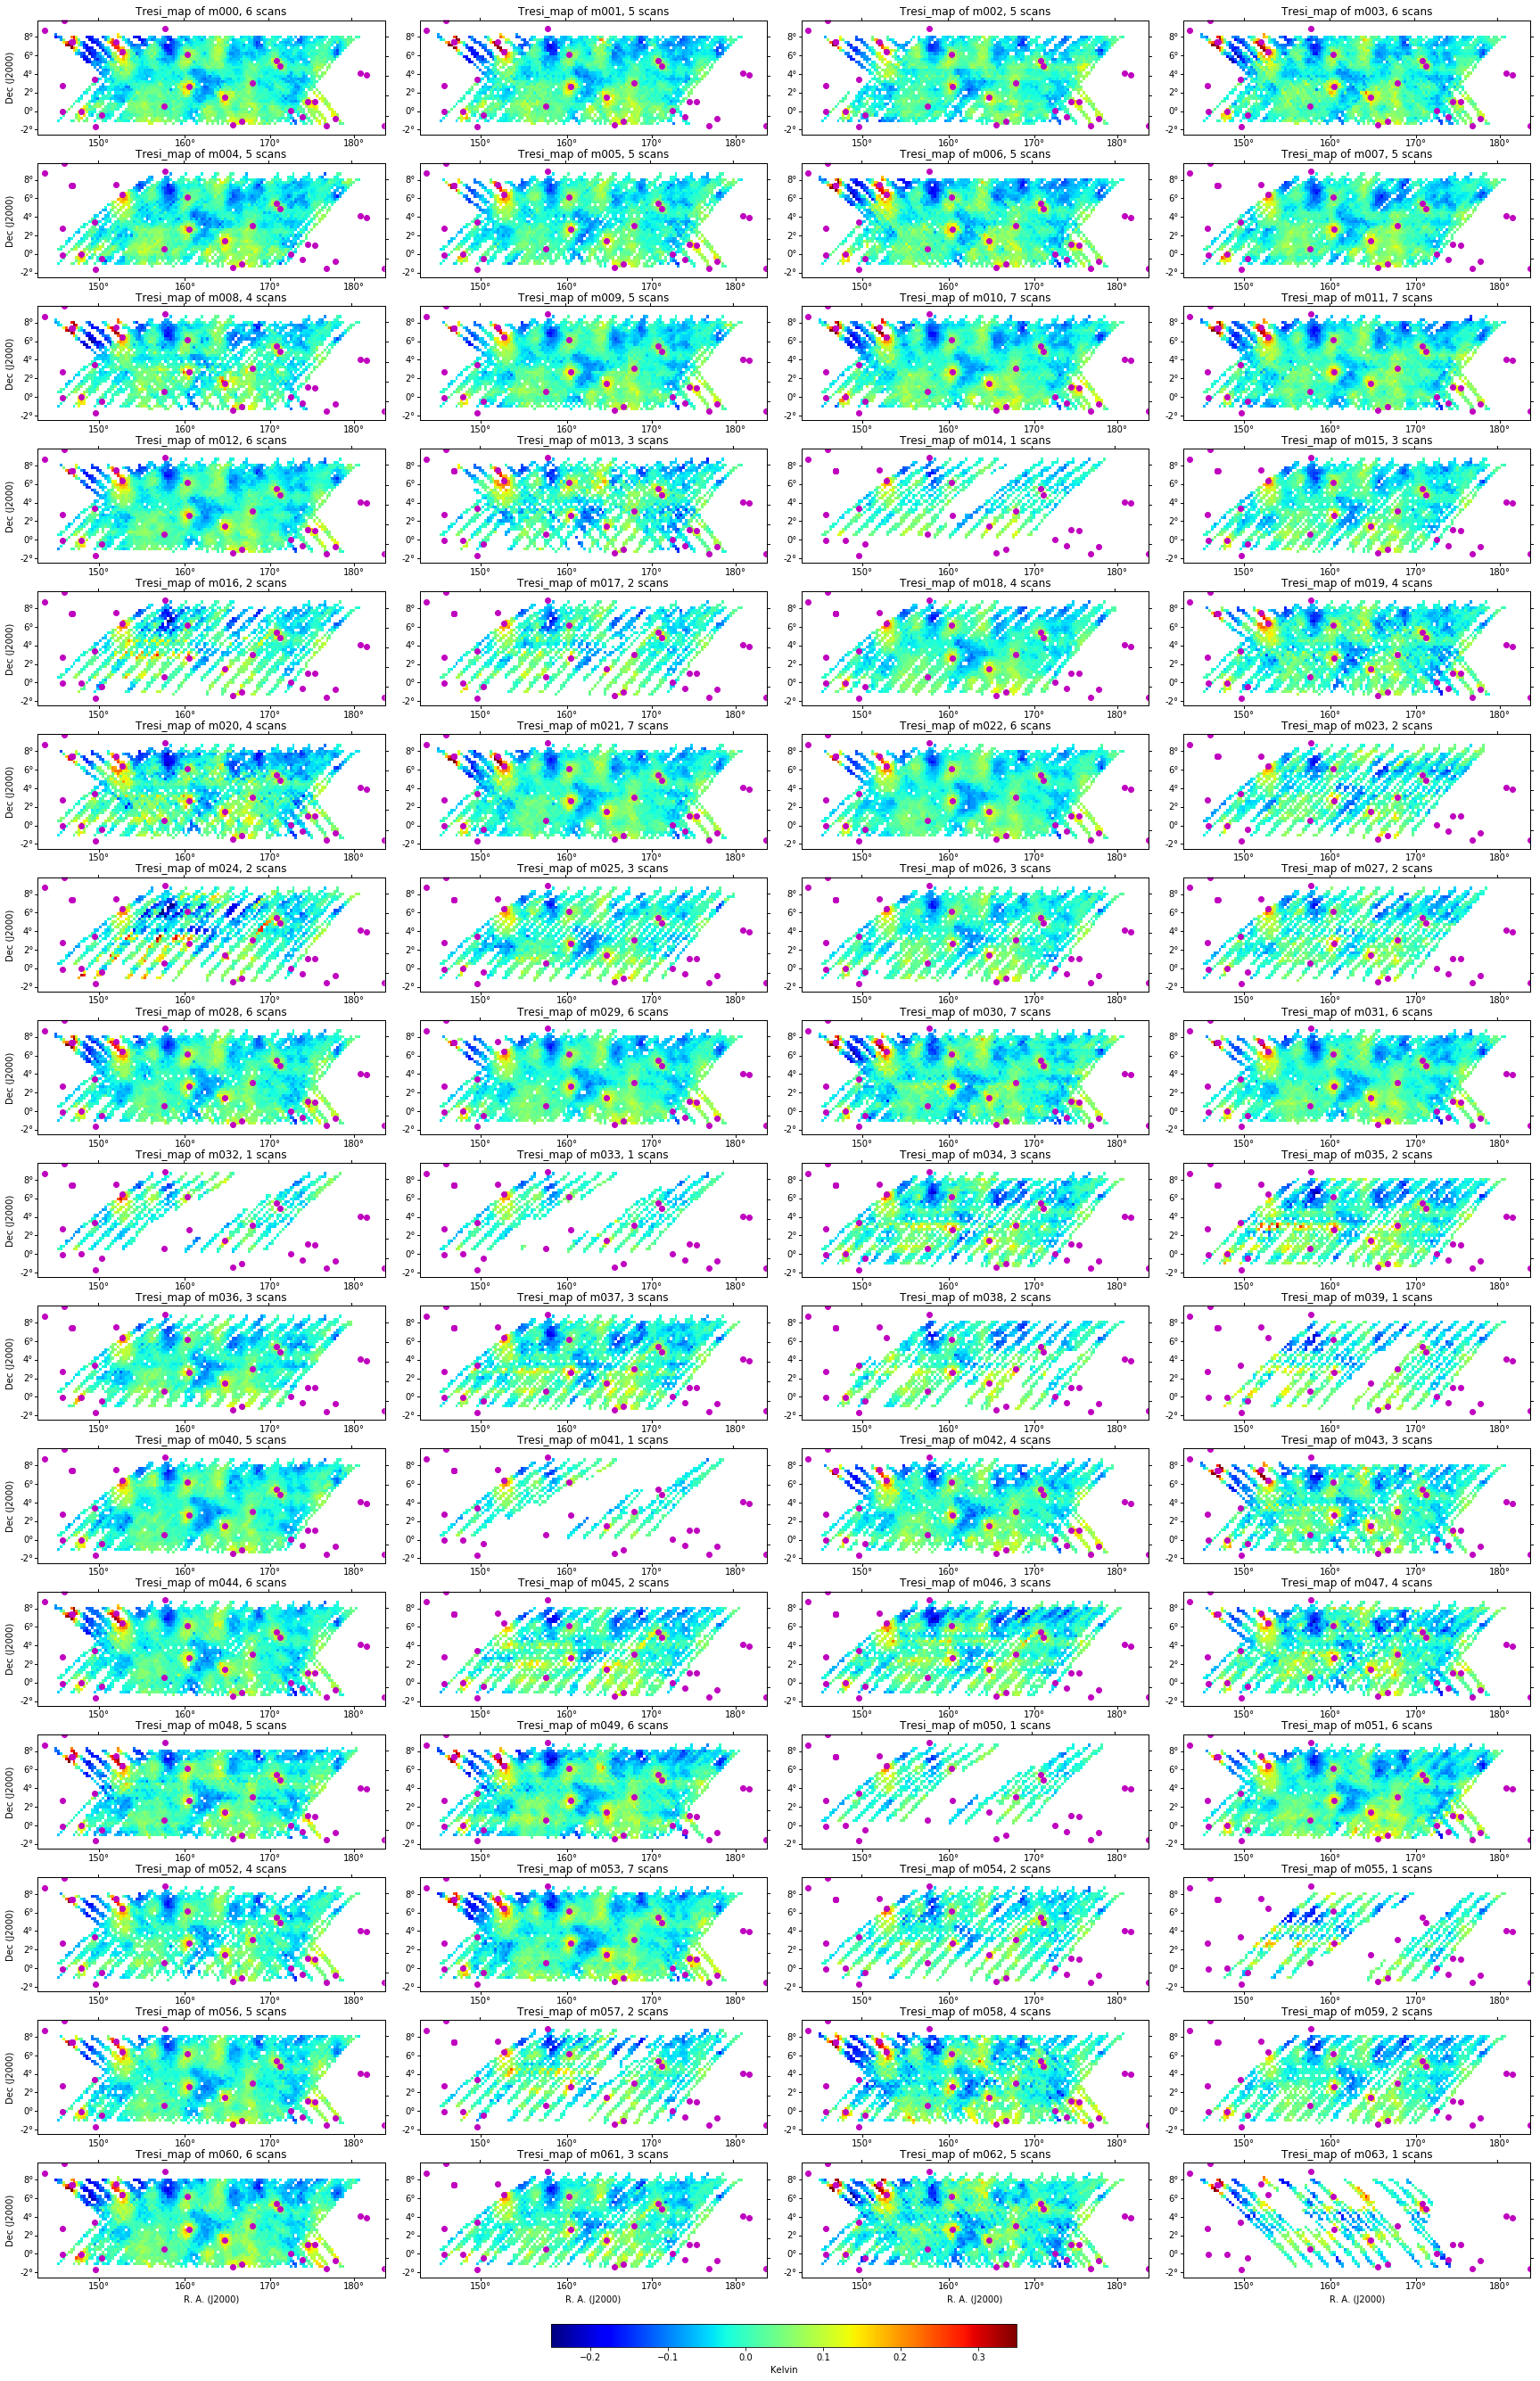

In [16]:

dish_count1=0 #cube count
dish_count_plot1=0 #channel count

fig =plt.figure(figsize=(30,48))
fig.subplots_adjust (wspace=0.1, hspace=0.25)
axes=[]

for a_i in range(64):
    ant='m'+ "%03d" % a_i
    #print ant
    
    for f_i in range(len(fname_list)):
        fname=fname_list[f_i]
        #print fname
        
        try:

            Fits1='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
            Tsky_cube = fits.open(Fits1)[0].data
            Fits2='/idia/projects/hi_im/raw_vis/katcali_output/level5_output/p'+str(pix_deg)+'d/Tmap/'+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits2)[0].data
            assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
            assert((np.isnan(Tresi_cube)).all()==False)
            #m=pickle.load(open(output_file+str(fname)+'_'+str(ant)+'_level6_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'_mask'))
            m=pickle.load(open('/idia/projects/hi_im/raw_vis/katcali_output/level6_output/p'+str(pix_deg)+'d/p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'/mask/'+str(fname)+'_'+str(ant)+'_level6_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'_mask'))
            ch_mask=m['ch_mask']
            dish_count1+=1 #cube count
            print '# cube '+str(dish_count1)+': '+fname+' '+ant
            
            if (dish_count1==1):
                Npix_x= np.shape(Tsky_cube)[0]
                Npix_y= np.shape(Tsky_cube)[1]

                w=WCS(Fits1).dropaxis(-1)
                w2=WCS(Fits2).dropaxis(-1)
                assert(w.wcs==w2.wcs)
                print '-------------------------------------------'
                print w
                print '-------------------------------------------'
                fits_temp1=np.zeros([Npix_x,Npix_y])

                Sum_Tsky_xy=fits_temp1.copy()
                Sum_Tresi_xy=fits_temp1.copy()
                Npix_xy_count1=fits_temp1.copy()
                Npix_xy_count2=fits_temp1.copy()
                assert((Sum_Tsky_xy==0).all()==True)
                assert((Sum_Tresi_xy==0).all()==True)
                assert((Npix_xy_count1==0).all()==True)
                assert((Npix_xy_count2==0).all()==True)
                print '***stastic cubes initialized'

            if ch_mask[ch_plot]==False and (np.isnan(Tsky_cube[:,:,ch_plot])).all()==False:
                Tsky_cube_1ch=Tsky_cube[:,:,ch_plot]
                Tresi_cube_1ch=Tresi_cube[:,:,ch_plot]
                dish_count_plot1+=1
                
                Sum_Tsky_xy[~np.isnan(Tsky_cube_1ch)]+=Tsky_cube_1ch[~np.isnan(Tsky_cube_1ch)]
                Sum_Tresi_xy[~np.isnan(Tresi_cube_1ch)]+=Tresi_cube_1ch[~np.isnan(Tresi_cube_1ch)]
                Npix_xy_count1[~np.isnan(Tsky_cube_1ch)]+=1
                Npix_xy_count2[~np.isnan(Tresi_cube_1ch)]+=1
            else:
                print 'no data loaded becasue',
                if ch_mask[ch_plot]==True:
                    print 'map for ch'+str(ch_plot)+', '+str(fname)+', '+ant+' masked.'
                if (np.isnan(Tsky_cube[:,:,ch_plot])).all()==True:
                    print 'all data is nan in ch'+str(ch_plot)

        except IOError:
            print 'no data cube for '+ fname+', '+ant

    Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
    Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

    print np.nanmean(Tsky_xy),np.nanstd(Tsky_xy)
    print np.nanmean(Tresi_xy),np.nanstd(Tresi_xy)
    
    ###make 64 subplot#########
    ax = plt.subplot(16,4,a_i+1,projection=w)
    axes.append(ax)
    
    #im = ax.imshow(Tsky_xy.T, aspect='auto',cmap='jet',vmin=2.9,vmax=3.7)
    #ax.set_title('Tsky_map of '+ant+', '+str(dish_count_plot1)+ ' scans', fontsize=12)
    
    im = ax.imshow(Tresi_xy.T, aspect='auto',cmap='jet',vmin=-0.25,vmax=0.35)
    ax.set_title('Tresi_map of '+ant+', '+str(dish_count_plot1)+ ' scans', fontsize=12)
    
    ax.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    ax.set_xlim([0,Npix_x])
    ax.set_ylim([0,Npix_y])
    #plt.colorbar()
    if a_i%4==0:
        ax.set_ylabel('Dec (J2000)')
    if a_i>59:
        ax.set_xlabel('R. A. (J2000)')
    #reset for each dish
    dish_count1=0
    dish_count_plot1=0
fig.colorbar(im, ax=axes,orientation="horizontal",fraction=0.01,label='Kelvin',pad=0.02)
#plt.savefig('Tsky64_ch'+str(ch_plot)+'_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'.pdf', bbox_inches='tight')
plt.savefig('Tresi64_ch'+str(ch_plot)+'_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'.pdf', bbox_inches='tight')
plt.show()


In [17]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Wed Jul  8 22:31:09 2020#
